In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [3]:
### Create function for Cressman Analysis ###

## this function returns a weight
def cressmanweights(dist,rad):
    dist = dist
    rad = rad
    if dist <= rad:
        w = (rad**2 - dist**2)/(rad**2 + dist**2)
    else:
        w = 0
    return w

## to be put into a for loop for each index in obs, where each weight is appended to a new array

## function for ***2nd*** pass analysis
def cressmananalysis(xg,yg,obsx,obsy,hght,firstpass,obs_inc,rad):
    cress = np.zeros(shape=(len(xg),len(xg[1])))
    for i in range(len(xg)):
        for j in range(len(xg[i])):
            xa = xg[i,j]
            ya = yg[i,j]
            dx = xa - obsx
            dy = ya - obsy
            dist = ((dx**2 + dy**2)**0.5)
            theseweights = np.zeros(shape=len(dist))
            for u in range(len(dist)):
                theseweights[u] = cressmanweights(dist[u],rad)
            ## weights array for this grid point should be full below this line
        
            ## iterate through each weight/ob to get analysis value at this point, using the blessed and magical += operator
            ## reset initial values for this pass
            bigk = len(obsx) - 1 ## number of observations, the -1 is for indexing reasons
            k = 0
            numsum = 0 ## this will be the numerator in the cressman analysis function, which is a summation
            denomsum = 0 ## denominator in the cressman analysis function, which is also a summation
        
            while k <= bigk:
                if theseweights[k] == 0:
                    k += 1
                    continue
                obsinc = obs_inc[k]
                numsum += (theseweights[k]) * obsinc
                denomsum += theseweights[k]
                k += 1

            if denomsum ==0:
                fa = np.nan
            else:
                fa = firstpass[i,j] + (numsum / denomsum) ## num and denom were summation-ed in the while loop above
            #print(fa)
            cress[i,j] = fa ## populates 1st pass grid with analysis values as they come
        #print('k loop end')
    return(cress)



In [4]:
### Create function for bilinear interpolation ###

def bilinear(obsx,obsy,xg,yg,cress1,prevrad):
    ## base value lat lons
    baselat = -0.063
    baselon = .189
    delta = 0.0127
    ## 1st, convert x and y indices of ob locations
    idx_x = (obsx - baselon)/delta ## redefines the origin and resizes the grid
    idx_y = (obsy - baselat)/delta ##  ^^^^^
    
    ## call an empty array for the bilinear interp values
    bi_val = np.zeros(shape=len(idx_x))

    ## remove indices that do not fit within the 0-22 and 0-28 criteria
    for m in range(len(idx_x)):
        if idx_x[m] > 21 or idx_x[m] < 0 or idx_y[m] > 27 or idx_y[m] < 0: ## 21 and 27 are the ceilings due to indexing being indexing
            idx_x[m] = np.nan
            idx_y[m] = np.nan ## this and above line mean that any ob with a recreated index value outside of the analysis grid is a nan value
            
            ## perform cressman analysis to interpolate points outside of the grid space and shovel directly into the bilinear interp 
            ## i fear that shoving this into another function would screw me up, so I am not going to do that
            xp = obsx[m]
            yp = obsy[m]
            theseweights = np.zeros(shape=(len(xg),len(xg[i])))
            for a in range(len(xg)):
                for s in range(len(xg[i])):
                    dx = xp - xg[a,s]
                    dy = yp - yg[a,s]
                    thisdist = ((dx**2 + dy**2)**0.5)
                    theseweights[a,s] = cressmanweights(thisdist,prevrad)
                    ## theseweights array only filled for singular ob location, so proceed w/ caution
            flat_weights = theseweights.flatten()
            flat_anhghts = cress1.flatten()
            bigk = len(flat_weights) - 1 ## number of analysis points, adjusted for index
            k = 0
            num = 0 ## as in cressman function
            denom = 0
            while k <= bigk:
                if flat_weights[k] == 0:
                    bi_val[m] = np.nan ## weight of zero means outside ROI, sets value to nan in interpolated array
                    #print('zero weight, restarting loop')
                    k += 1
                    continue
                else:
                    num += (flat_weights[k]) * (flat_anhghts[k])
                    denom += flat_weights[k]
                    k += 1
            if denom == 0:
                bi_val[m] = np.nan ## a secondary check, to avoid the nefarious divide by zero error
            else:
                an_val = num / denom
                bi_val[m] = an_val
        ## above process should retain the nan value in the idx_x and idx_y arrays so the bilinear part of this function doesn't break
        else:
            continue
    ## next up, take each grid point and find the lower left nearest grid point index
    bl_x = np.zeros(shape=len(idx_x))
    bl_y = np.zeros(shape=len(idx_y))
    for n in range(len(idx_x)):
        bl_x[n] = np.floor(idx_x[n])
        bl_y[n] = np.floor(idx_y[n])
    #print(bl_x,bl_y)
    
    ## establish tl,br,tr indices
    for w in range(len(bl_x)):
        #print(bl_x[w])
        if np.isnan(bl_x[w]):
            #bi_val[w] = np.nan
            ## above line was implemented before the reverse cressman was added
            ## now, the function will skip over the pre-filled bi_val spots b/c corresponding x index is still nan
            continue
        else:
            x = idx_x[w]
            y = idx_y[w]
            blx = int(bl_x[w])
            bly = int(bl_y[w])
            brx = blx + 1
            bry = bly
            tlx = blx
            tly = bly + 1
            trx = tlx + 1
            tr_y = tly + 1
            #print(blx,bly)
            blv = cress1[bly,blx]
            tlv = cress1[bly+1,blx]
            brv = cress1[bly,blx+1]
            trv = cress1[bly+1,blx+1]
            ## get a left and right to bilinear-ize
            lv = blv + ((tlv - blv) * (y-bly))
            rv = brv + ((trv - brv) * (y-bry))
            biv = lv + ((rv-lv) * (x-blx)) ## originally x-brx
            bi_val[w] = biv
            #print(blv,tlv,brv,trv)
    return(bi_val) ## bi_val contains all interpolated analysis values, with values outside of the domain set to nan       

#bilinear(obsx,obsy,cress1)


In [6]:
### Read in observations ###
dat = np.loadtxt('RAOBs_201903131200.txt',delimiter=',',skiprows=0,usecols=(1,2,3,4,5))
#print(dat)
datt = dat.T
## datt array has lats; lons; 500mb heights; wind direction; wind speed in that order as the rows
## shove all of these fields into their own arrays to call by name
lat = datt[0]
lon = datt[1]
hght = datt[2]
wdir = datt[3]
wspd = datt[4]

r = 6371000 #units of meters
scale = 1/15000000
## grab the min max of lons and lats for future reference
minlat = np.min(lat)
maxlat = np.max(lat)
minlon = np.min(lon)
maxlon = np.max(lon)

In [7]:
### Set up analysis map with a 22x28 rectangular grid of points ###
## create evenly spaced point grid
def grid():#(shape=(22,28)):
    ## get grid point locations, using values already in meters because i'm allergic to nonstandard units
    #glon = np.arange(.189,((.0127*28)+.189),.0127)
    glon = .189 + (np.arange(22)*0.0127)
    glat = -0.063 + (np.arange(28)*0.0127)
    #glat = np.arange((-.0630+(.0127*21)),-.0630+.0127,.0127) ## i never claimed to be an efficient programmer
    return(glon,glat)

glon,glat = grid()

## shove it all into meshgrid to get actual gridpoints out of this
xg,yg = np.meshgrid(glon,glat)

## plot for quality control
#plt.plot(xg,yg,color='black',marker='o',linestyle='none')


In [8]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###

## create analysis points lat/lon array
obsloc = np.zeros(shape=(len(lat),2)) ## to be filled with values
for i in range(len(lat)):
    pointlat = lat[i]
    pointlon = lon[i]
    obsloc[i] = pointlat,pointlon ## now, each row will have a lat/lon pair in that order
#print(obsloc)
dx = .0127
dy = .0127
rho = 6371000

m = 1/15000000

x0 = .1890
y0 = -.0630
l0 = (-115 * np.pi/180)
## define function to take the lat/lon points and convert them to centimeter locations using the long and frankly ridiculous formula from the notes
def obsdist(lat,lon):
    sig = (1 + np.sin(60 * np.pi/180))/(1 + np.sin(lat * np.pi/180)) ## have to bake in the radians conversion because that's how numpy rolls ig
    x = m * rho * sig * np.cos(lat * np.pi/180) * np.cos((lon * np.pi/180)-l0)
    y = m * rho * sig * np.cos(lat * np.pi/180) * np.sin((lon * np.pi/180)-l0)
    return(x,y)

obsxy = np.zeros(shape=(len(lat),2))
for i in range(len(lat)):
    this_latlon = obsloc[i]
    this_lat = this_latlon[0]
    this_lon = this_latlon[1]
    x,y = obsdist(this_lat,this_lon)
    obsxy[i] = x,y
## incredibly cringe how long the above block of code took me

obsxyt = obsxy.T
obsx = obsxyt[0]
obsy = obsxyt[1]

#plt.plot(obsx,obsy,color='blue',marker='o',linestyle='none')
#plt.plot(xg,yg,color='black',marker='o',linestyle='none')

## this looks stoopid
## whatever

#print(obsxy)

## create analysis x,y to analysis lat,lon function
def latlon(x,y):
    #alat = ((np.pi/2) * (180/np.pi)) - ((2*np.arctan(((x**2 + y**2)**.5)/(rho * (1 + np.sin(60 * np.pi/180))))) / (np.pi/180))
    alat = ( (np.pi/2) - (2 * np.arctan((((x**2) + (y**2))**0.5)/(rho * (1 + np.sin(60 * np.pi/180)))))/m ) * (180/np.pi)
    alon = -115 - (np.arctan(y/x) / (np.pi/180)) 
    return(alat,alon)

## toss analysis points through the latlon function defined
alat,alon = latlon(xg,yg)
## aaaand toss those outputs into a meshgrid
anlat,anlon = np.meshgrid(alat,alon)


In [9]:
## finding dmin; avg. distance between nearest rawinsondes in dataset
## in other words, it's the average of the minimum distance from observation to observation
## so for each ob, find the distances between that ob and each other ob
## then find the minimum of those distances
## rinse and repeat for all other obs
## this is a reminder to myself that all of these are in meters

## anyways
## if gross overuse of looping functions is a crime, i will accept a life sentence with zero regrets

mindist = np.zeros(shape=len(obsxy))

for x in range(len(obsxy)):
    thisx = obsxy[x,0]
    thisy = obsxy[x,1]
    thesedist = np.zeros(shape=len(obsxy))
    for i in range(len(obsxy)):
        compx = obsxy[i,0]
        compy = obsxy[i,1]
        dx = compx - thisx
        dy = compy - thisy
        thisdist = ((dx**2 + dy**2)**0.5)
        if thisdist == 0:
            thesedist[i] = 9999999 
            ## this is an astronomically stupid way of getting to the result I want and I am fully aware of that
            ## all of my code is held together with duct tape and prayer
        else:
            thesedist[i] = thisdist
    mindist[x] = np.min(thesedist)

dmin = np.mean(mindist)

In [10]:
### Perform 500mb geopotential height analyses using a Cressman weighting Function###
#Use radii of influence 4, 2.5, 1.5 *dmin
rad4 = 4 * dmin
rad25 = 2.5 * dmin
rad15 = 1.5 * dmin

## call empty zeros array for analysis vals
cress1 = np.zeros((28,22))

## time to do some roundabout, backwards garbage
## analysis x and y values stored as xg, yg

## iterate through analysis gridpoints
for i in range(len(xg)):
    for j in range(len(xg[i])):
        xa = xg[i,j]
        ya = yg[i,j]
        dx = xa - obsx
        dy = ya - obsy
        dist = ((dx**2 + dy**2)**0.5)
        theseweights = np.zeros(shape=len(dist))
        for u in range(len(dist)):
            theseweights[u] = cressmanweights(dist[u],rad4) ## creates an array of weights corresponding to obs
        ## weights array for this grid point should be full below this line
        
        ## iterate through each weight/ob to get analysis value at this point, using the blessed and magical += operator
        ## reset initial values for this pass
        bigk = len(obsxy) - 1 ## number of observations, the -1 is for indexing reasons
        k = 0
        num = 0 ## this will be the numerator in the cressman analysis function, which is a summation
        denom = 0 ## denominator in the cressman analysis function, which is also a summation
        
        while k < bigk:
            if theseweights[k] == 0:
                k += 1
                continue
            num += (theseweights[k]) * (hght[k])
            denom += theseweights[k]
            k += 1
        
        fa = num / denom ## num and denom were summation-ed in the while loop above
        
        cress1[i,j] = fa ## populates 1st pass grid with analysis values as they come
        #print('k loop end')
#print(cress1.shape)

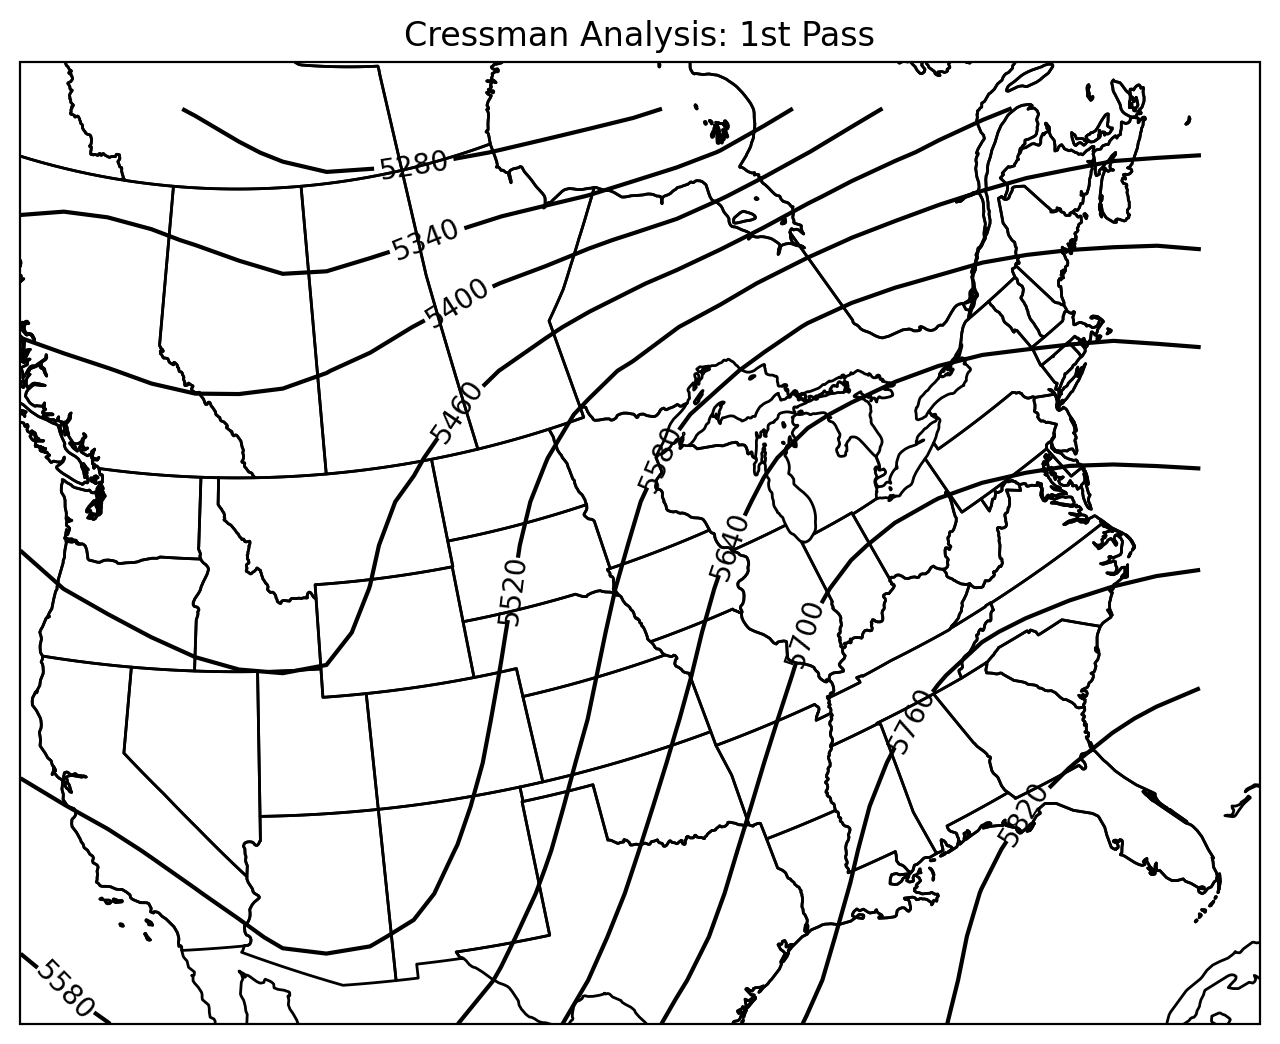

In [11]:
### First analysis, no successive corrections ###

## plot yay
def latlon(x,y):
    #lat = ((np.pi/2) - (2*np.arctan((((((x/m)**2 + (y/m)**2)**.5)/(rho * (1 + np.sin(60 * np.pi/180))))*np.pi/180)))) * (180/np.pi)
    lat = ((np.pi/2) - (2 * np.arctan( (((x/m)**2 + (y/m)**2)**.5) / (rho * (1 + np.sin(60 * (np.pi/180)))) ))) * (180/np.pi)
    lon = np.arctan(y/x)*(180/np.pi) - 115
    return(lat,lon)

anlat,anlon = latlon(xg,yg)
#print(latlon(xg,yg))
#print(anlon)

## plot starts here 
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis 
cs1 = ax1.contour(anlon,anlat,cress1,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Cressman Analysis: 1st Pass')
plt.savefig('cressman_1.png',dpi=200,bbox_inches='tight')
plt.show()

In [12]:
### Next Analyses ###
## step 1: bilinear interpolation (my detested, my beloathed, my #1 opponent)
an_atobs_1 = bilinear(obsx,obsy,xg,yg,cress1,rad4) ##obs x and obs y are retained in same index vals as always
##cress1 has shape 28,22
print('cressman 1st pass, analysis at ob loc')
print(cress1)
print()
print(an_atobs_1)
obs_inc_1 = hght - an_atobs_1 ## incrememnt between first and second pass
#print(obs_inc)
print()

##2nd pass using predefined function with a heinous number of inputs
print('cressman 2nd pass, analysis at ob loc')
cress2 = cressmananalysis(xg,yg,obsx,obsy,hght,cress1,obs_inc_1,rad25)
print(cress2)
## bilinear interpolate the 2nd pass obs locations
an_atobs_2 = bilinear(obsx,obsy,xg,yg,cress2,rad25) ## 2.5dmin is previous roi
obs_inc_2 = hght - an_atobs_2
print()

print(an_atobs_2)
cress3 = cressmananalysis(xg,yg,obsx,obsy,hght,cress2,obs_inc_2,rad15)
print('cressman 3rd pass, analysis at ob loc')
## for rms 
an_atobs_3 = bilinear(obsx,obsy,xg,yg,cress3,rad15)
print()
print(cress3)
print()
print(an_atobs_3)


cressman 1st pass, analysis at ob loc
[[5292.92597057 5312.20484356 5331.04124837 5351.57868458 5374.32801028
  5396.09106884 5412.02092463 5424.97997388 5437.3444126  5448.69778804
  5459.01592307 5467.02728059 5477.37903863 5490.55717128 5502.3450854
  5515.07271135 5529.06977571 5542.92724291 5558.73839687 5575.14452015
  5587.70030511 5599.79042578]
 [5296.39988062 5314.07276142 5333.0245193  5352.46394958 5373.28189648
  5390.89013882 5405.99275174 5419.21114988 5432.65866094 5442.92852243
  5452.20610665 5459.89849732 5471.1680421  5483.09270124 5494.14919822
  5506.80853123 5520.62137083 5534.62703412 5548.45975024 5564.23409088
  5577.39412193 5587.83527343]
 [5294.54047626 5310.96259129 5330.21373129 5350.24433327 5369.00480597
  5386.02597707 5400.98210606 5414.28070887 5426.56030353 5437.89769706
  5446.42711208 5453.66799026 5464.56414954 5476.28532028 5487.28417507
  5499.76390774 5512.88064664 5526.6308383  5539.07452569 5553.64707812
  5568.54406701 5580.47808571]
 [5286

In [15]:
### Calculate Analysis Differences
## difference between 1st and 2nd passes
diff12 = cress2 - cress1
diff23 = cress3 - cress2

diff13 = cress3 - cress1

## RMS errors 

def rmse(ob,an,num_obs):
    insummation = 0
    diff = ob - an
    #print(diff)
    numnans = np.count_nonzero(np.isnan(diff))
    num_real = num_obs - numnans
    #print(num_diff)
    for i in range(len(diff)):
        if np.isnan(diff[i]):
            insummation += 0
            continue
        else:
            #print(diff[i])
            insummation += ((diff[i])**2)
            #print(insummation)
            #print(num_diff)
            continue
    print(num_obs,insummation)
    rmse = (insummation / num_real)**0.5
    return rmse


rms1 = rms(hght,an_atobs_1,len(hght))
rms2 = rms(hght,an_atobs_2,len(hght))
rms3 = rms(hght,an_atobs_3,len(hght))

print(rms1,rms2,rms3)




135 676348.3942990436
135 134667.04492494982
135 19310.175232220212
73.55805295406036 33.92639656630114 13.249416876437932


In [ ]:
### Plot 500mb analyses over a map ###
#use old code...
def latlon(x,y):
    #lat = ((np.pi/2) - (2*np.arctan((((((x/m)**2 + (y/m)**2)**.5)/(rho * (1 + np.sin(60 * np.pi/180))))*np.pi/180)))) * (180/np.pi)
    lat = ((np.pi/2) - (2 * np.arctan( (((x/m)**2 + (y/m)**2)**.5) / (rho * (1 + np.sin(60 * (np.pi/180)))) ))) * (180/np.pi)
    lon = np.arctan(y/x)*(180/np.pi) - 115
    return(lat,lon)

anlat,anlon = latlon(xg,yg)

## 2nd pass plot starts here 
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis 
cs1 = ax1.contour(anlon,anlat,cress2,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Cressman Analysis: 2nd Pass')
plt.savefig('cressman_2.png',dpi=200,bbox_inches='tight')
plt.show()

## again for pass 3
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis 
cs1 = ax1.contour(anlon,anlat,cress3,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Cressman Analysis: 3rd Pass')
plt.savefig('cressman_3.png',dpi=200,bbox_inches='tight')
plt.show()

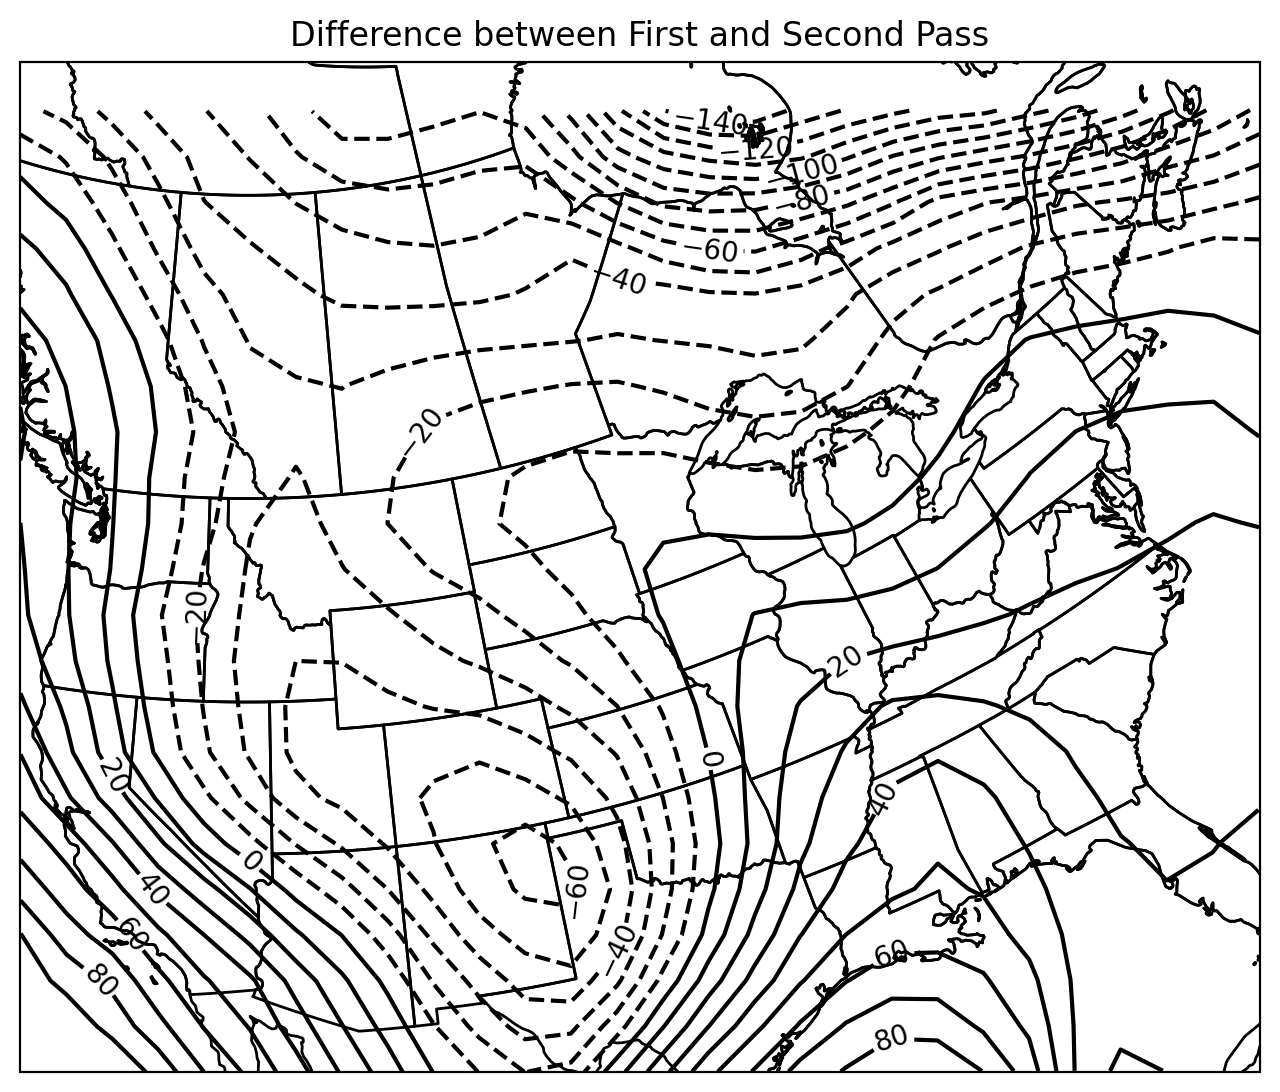

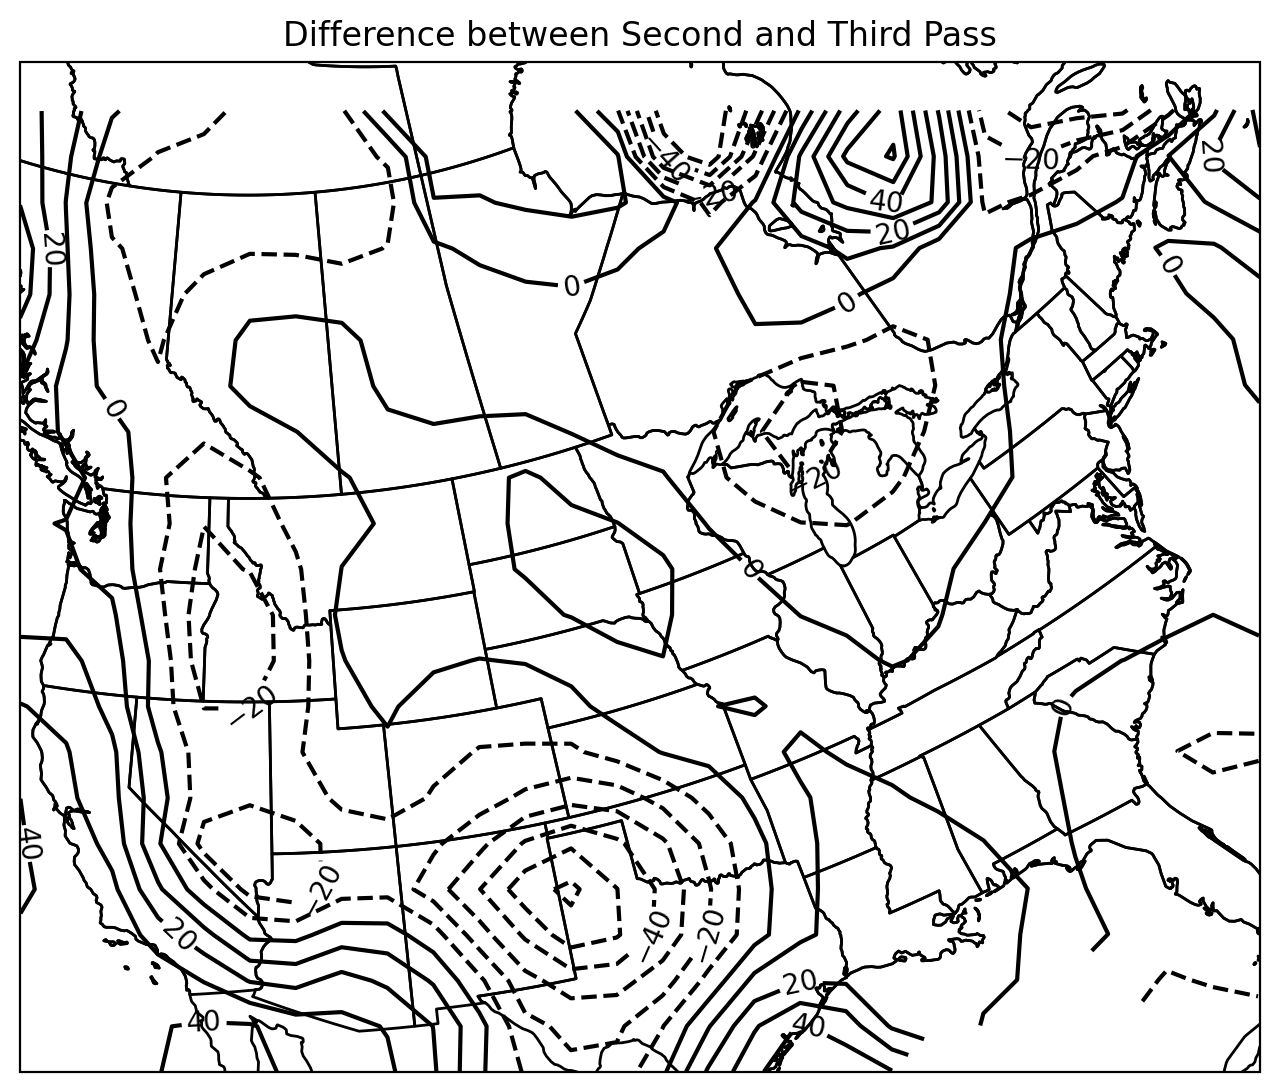

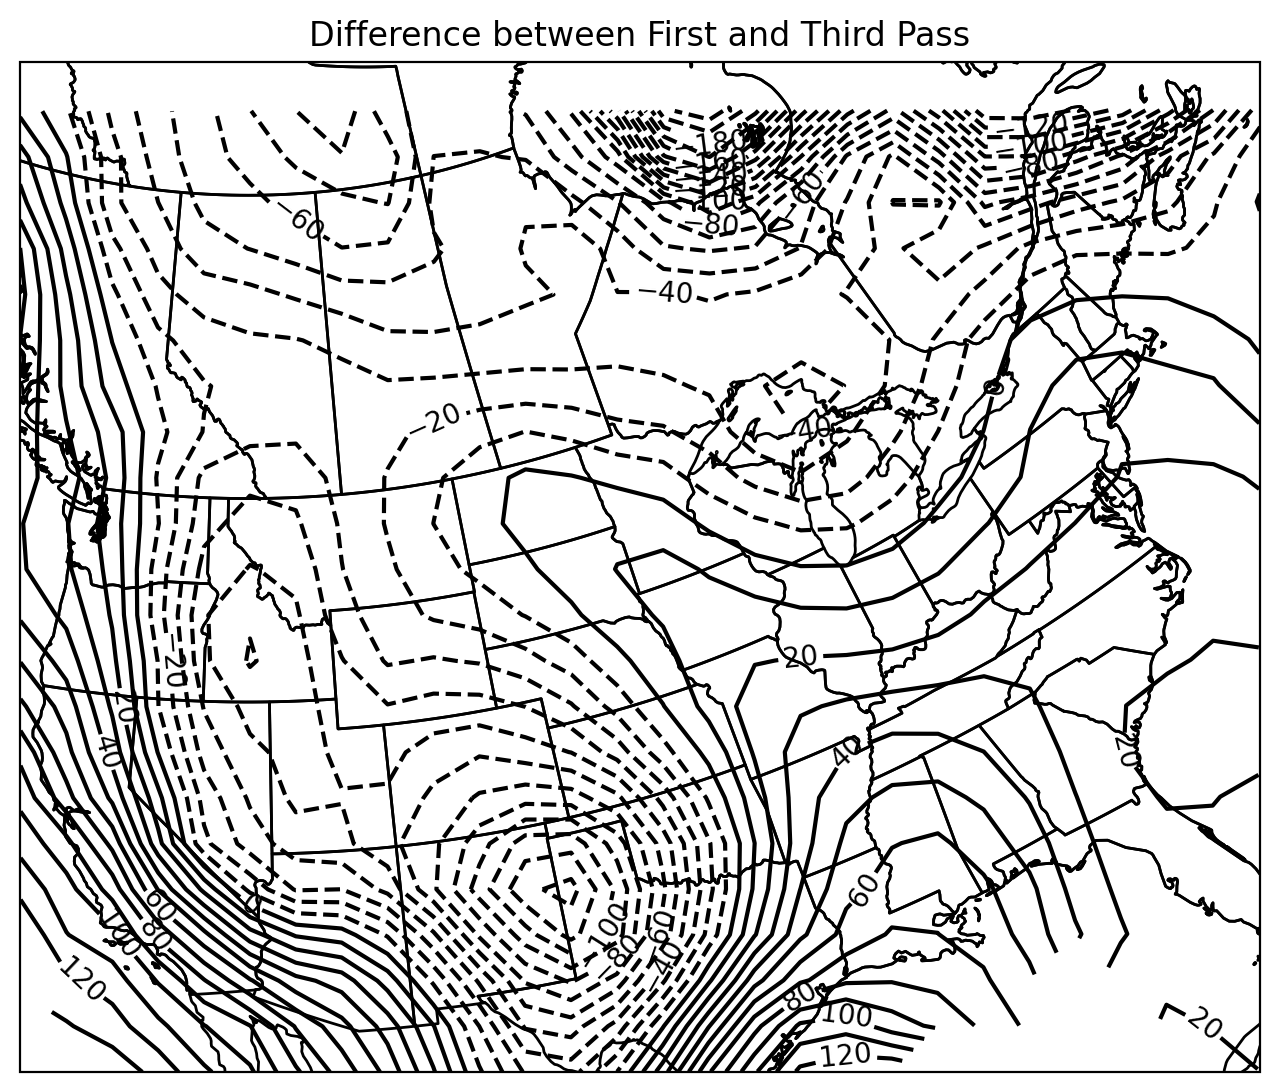

In [15]:
### Plot Analysis Differences ###

## 1st to 2nd pass
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis 
cs1 = ax1.contour(anlon,anlat,diff12,colors='k',levels=np.arange(-8000,8000,10),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20))
plt.title('Difference between First and Second Pass')
plt.savefig('1stto2nd_difference.png',dpi=200,bbox_inches='tight')
plt.show()

###########################

## 2nd to 3rd pass
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis 
cs1 = ax1.contour(anlon,anlat,diff23,colors='k',levels=np.arange(-8000,8000,10),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20))
plt.title('Difference between Second and Third Pass')
plt.savefig('2ndto3rd_difference.png',dpi=200,bbox_inches='tight')
plt.show()

############################

## difference between 1st and 3rd pass
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis 
cs1 = ax1.contour(anlon,anlat,diff13,colors='k',levels=np.arange(-8000,8000,10),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20))
plt.title('Difference between First and Third Pass')
plt.savefig('1stto3rd_difference.png',dpi=200,bbox_inches='tight')
plt.show()

In [16]:
### Store the analyses in text files ###
pass1 = open('cressman1stpass.txt','w')

pass1.write('The following are analysis values for a 1st-pass Cressman analysis: ')

for i in cress1:
    j = i.astype(str)
    pass1.write(f'{j}')

pass1.close()

pass2 = open('cressman2ndpass.txt','w')
pass2.write('The following are analysis values for a 2nd-pass Cressman analysis: ')

for i in cress2:
    j = i.astype(str)
    pass2.write(f'{j}')

pass2.close()

pass3 = open('cressman3rdpass.txt','w')
pass3.write('The following are analysis values for a 3rd-pass Cressman analysis: ')

for i in cress3:
    j = i.astype(str)
    pass3.write(f'{j}')

pass3.close()

In [17]:
### Store the difference fields in text files ###
diff_1to2 = open('1stto2nddiff.txt','w')
diff_1to2.write('The following are the differences at each analysis location between the first and second pass analysis values: ')

for i in diff12:
    j = i.astype(str)
    diff_1to2.write(f'{j}')

diff_1to2.close()

diff_2to3 = open('2ndto3rddiff.txt','w')
diff_2to3.write('The following are the differences at each analysis location between the second and third pass analysis values: ')

for i in diff23:
    j = i.astype(str)
    diff_2to3.write(f'{j}')

diff_2to3.close()

diff_1to3 = open('1stto3rddiff.txt','w')
diff_1to3.write('The following are the differences at each analysis location between the first and third pass analysis values: ')

for i in diff13:
    j = i.astype(str)
    diff_1to3.write(f'{j}')

diff_1to3.close()

In [18]:
### Store RMS values in text file ###

rmsvals = open('rmsvalues.txt','w')
rmsvals.write(f'The following are the RMSE values for the 1st, 2nd, and 3rd pass analyses, respectively: {rms1}, {rms2}, {rms3}')
rmsvals.close()

## for the record: I know these values are off. I am also fairly certain they're off because of an issue with my bilinear interpolation function.

In [19]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

    There is a trough with an axis centered over the intermountain West. It has a slight negative 
    tilt that is evident in the 2nd and 3rd passes, but the tilt is less obvious in the 1st pass.
    A complementary ridge is centered over Florida, with an axis extending northward towards the 
    Great Lakes region. 

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
    In the second and third passes, the height gradient at the base of the trough
    appears stronger than in the first. In the third pass, the 5400m isopleth reaches as far south
    as Idaho, whereas in previous passes, it remained over Canada. The third pass has a few more
    jagged contours than the previous two, and the first pass appears the smoothest. This is because
    the first pass has the largest ROI, and will therefore "smooth out" more of the data rather than
    capturing smaller features. However, in subsequent passes, when the ROI decreases, there are
    fewer points for the analysis function to take into consideration, allowing smaller features to
    remain visible. After the first pass, these smaller features are pulled back out of the previously
    smoothed data.

3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?

    As the number of passes increases, the analysis converges to the observations at the observation
    locations. For the purpose of analysis, this may not be desirable, because data may be sparse
    in one location as opposed to another (density issue), or data readings may be erroneous. However, 
    if observations are assumed to be perfect, and there is no background field available, convergence 
    to observations may be more desirable.
    
    

'''

'\n1 - Describe the general features that you see in your contoured analyses.\n\n    There is a trough with an axis centered over the intermountain West. It has a slight negative \n    tilt that is evident in the 2nd and 3rd passes, but the tilt is less obvious in the 1st pass.\n    A complementary ridge is centered over Florida, with an axis extending northward towards the \n    Great Lakes region. \n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n    \n    In the second and third passes, the height gradient at the base of the trough\n    appears stronger than in the first. In the third pass, the 5400m isopleth reaches as far south\n    as Idaho, whereas in previous passes, it remained over Canada. The third pass has a few more\n    jagged contours than the previous two, and the first pass appears the smoothest. This is because\n    the first pass has the largest ROI, a